In [2]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
mode = 'theory' #or 'theory'
if mode == 'theory':
    n_seeds = 1
    macro_configs = config_generator(rho_1=list(np.round(np.arange(-0.6, 0.8, 0.2),2)),
                                     g=[3, 6, 10],
                                     PR_D=[0.3, 0.8, 1])
if mode == 'sim':
    n_seeds = 10
    macro_configs = config_generator(rho_1=[0.3]+list(np.round(np.arange(-0.6, 0.8, 0.2),2)),
                                     g=[3, 6, 10],
                                     PR_D=[0.3, 0.8, 1])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [155]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
g = params['g']
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)

#lags window
T_window_emp = 20
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [159]:
### --- Generate LDRG matrix --- ###

alpha = 1
K = int(alpha * N)
#PR_D = params['PR_D']
PR_D = params['PR_D']
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(K)/K)
else:
    D = np.ones(K)
g_correction = g / np.sqrt(np.sum(D**2)/N)
D = D * g_correction

rho_dist = 'sigmoidal'
### --- Uniform random rho --- ###
if rho_dist == 'uniform':
    rho = np.random.uniform(-1, 1, N)
    gamma = params['gamma']
    #gamma = 10
    rho_max = params['rho_max']
    #rho_max = 0.1
    #rho_offset = params['rho_offset']
    rho_offset = 0
    rho = rho * rho_max*(D/D[0])**gamma + rho_offset

### -- Sigmoidal rho --- ###
if rho_dist == 'sigmoidal':
    sigmoid = lambda x: 1/(1+np.exp(-x))
    def generate_rho(rho_1, rho_2, f_transition, N):
        return rho_1 + (rho_2 - rho_1) * sigmoid(2*(8*(np.arange(N)/N) - 8 * f_transition))
    transition_dict = {'1': 0.5, '0.8': 0.4, '0.3': 0.22}
    transition = transition_dict[str(PR_D)]
    rho = generate_rho(params['rho_1'], -params['rho_1'], transition, N)

X1 = np.random.normal(0, 1, (N, N))
X2 = np.random.normal(0, 1, (N, N))
Y = np.random.normal(0, 1, (N, N))
L = np.sqrt((1 - np.abs(rho))/N)*X1 + np.sqrt(np.abs(rho)/N)*Y
RT = (np.sqrt((1 - np.abs(rho))/N)*X2 + np.sign(rho)*np.sqrt(np.abs(rho)/N)*Y).T

L = torch.from_numpy(L).type(torch.FloatTensor).to(0)
D_ = torch.from_numpy(D).type(torch.FloatTensor).to(0)
RT = torch.from_numpy(RT).type(torch.FloatTensor).to(0)

W = torch.einsum('ik, k, kj -> ij', L, D_, RT)
del L
del RT

In [ ]:
### --- Estimate psi empirically --- ###

compute_empirical_psi = (mode == 'sim')
if compute_empirical_psi:
    W_ = W
    Psi = estimate_Psi_with_on_diagonals(lags_emp, T_sim=2000, dt_save=dT_emp, dt=0.05, mode='tau_0',
                                         W=W_, phi_torch=phi_torch, T_save_delay=1000, N_batch=1, N_loops=40,
                                         runga_kutta=True)

    #symmetrize psi for comparison
    Psi_emp = Psi.cpu().detach().numpy()
else:
    Psi_emp = np.zeros_like(lags_emp)

In [5]:
### --- Estimate C empirically --- ###

#lags window
T_window_emp = 120
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

compute_empirical_psi = (mode == 'theory')
if compute_empirical_psi:
    W_ = W
    x, r = sample_activity(T_sim=5000, dt_save=dT_emp, dt=0.05, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=1000)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)[:,None,:]
    C_emp = compute_lagged_xcov(r, r, lags_emp, dt_save=dT_emp)

    #symmetrize C_emp for comparison
    C_emp = C_emp.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = np.concatenate([C_emp[-n_lags_emp:][::-1], C_emp[1:n_lags_emp]])
    lags_emp_full = np.concatenate([-lags_emp[-n_lags_emp:][::-1], lags_emp[1:n_lags_emp]])
else:
    lags_emp_full = np.concatenate([-lags_emp[-n_lags_emp:][::-1], lags_emp[1:n_lags_emp]])
    C_emp = np.zeros_like(lags_emp_full)

In [6]:
### --- Set theory parameters --- ###
T_window = 120
#dT = 0.02
dT = 0.04
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

In [7]:
if mode == 'theory':
    #run DMFT solver loop
    C_dmft, S_dmft = util.solve_dmft(
        update_fn=(lambda C, S:
                   util.update_LDR_sym(D_.to(0),
                                       torch.tensor(rho).to(0),
                                       C, S, N_samples=4096, dt=dT)),
        callback_fn=None,
        init_dt=dT,
        N_t=int((2*T_window)/dT),
        num_iter=120,
        device=0,
        alpha=0.8,
        final_avg_iter=20)

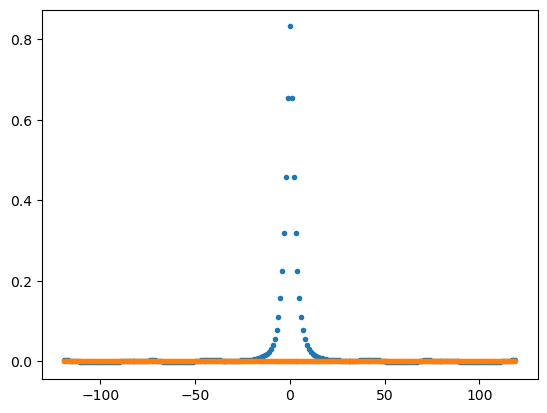

In [8]:
#C = C_dmft.cpu().numpy()
#T = len(C)
#t_indices= np.concatenate([np.arange(-T//2, 0), np.arange(0, T//2)])
#plt.plot(lags_emp_full, C[t_indices][::int(dT_emp/dT)][1:], '.')
#plt.plot(lags_emp_full, C_emp, '.')

In [22]:
### --- Compute Psi from theory --- ###

if mode == 'theory':
    C_phi = C_dmft.cpu().numpy()
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(-T//2, 0), np.arange(0, T//2)])
    #C_phi = C[t_indices]
    C_phi_omega = fft(C_phi, dT)
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)


    S_phi = np.sqrt(2*np.pi)*S_dmft.cpu().numpy()
    S_phi_omega = fft(S_phi, dT)
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

#Compute psi for LDR sym network

compute_theoretical_psi = (mode == 'theory')
#N_samples = 100
if compute_theoretical_psi:
    u_tilde = 0
    v_tilde = 0
    w_tilde = 0
    x_tilde_12 = 0
    samples = list(range(0, N, 5))
    measure = 1/len(samples)
    for i_sample in samples:
        #i_sample = np.random.choice(list(range(N)))
        d = D[i_sample]
        #rho_ = rho[i_sample]
        rho_ = rho[i_sample]
        #rho_ = np.random.uniform(-1, 1)*rho_max*(d/D[0])**gamma + rho_offset
        Q = d * S_phi_omega / (1 - d * rho_ * S_phi_omega)
        u_tilde += np.multiply.outer(Q, Q) * measure
        v_tilde += np.multiply.outer(np.abs(Q)**2, np.abs(Q)**2) * measure
        w_tilde += np.multiply.outer(rho_*np.conj(Q), rho_*Q) * measure
        x_tilde_12 += np.multiply.outer(rho_*Q, np.abs(Q)**2) * measure

    xxw = (1 + x_tilde_12) * (1 + np.conj(x_tilde_12.T)) / (1 - np.conj(w_tilde))

    M = (v_tilde - 1 + xxw + np.conj(xxw)) / (np.abs(1 - u_tilde)**2)
    Psi_omega1_omega2 = M * C_phi_C_phi
    Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
    Psi_tau_0 = Psi_tau1_tau2[:,0].real
else:
    pass

In [ ]:
if mode == 'theory':
    processed_data = np.array([Psi_tau_0])
if mode == 'sim':
    processed_data = np.array([Psi_emp])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [10]:
###Truncate file above
file_name = 'LDR_sym_Psi_theory_match'
job_name = 'LDR_sym_Psi_match_rho_theory'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook LDR_sym_Psi_theory_match.ipynb to script
[NbConvertApp] Writing 21338 bytes to LDR_sym_Psi_theory_match.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b6ffef395d0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b6ffef395d0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [11]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='PRL_Submission')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False, results_subdir='PRL_Submission',
           lkumar=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/PRL_Submission/LDR_sym_Psi_match_rho_theory/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/

In [139]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3563209    lkumar  jupyter   om2382  R   21:44:45      1 ax14


In [4]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'LDR_sym_Psi_match_rho_theory'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [5]:
job_name = 'LDR_sym_Psi_match_rho_sim'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [153]:
### --- Save packaged results --- ###
with open('packaged_results/LDR_sym_PR_match_rho1_theory', 'wb') as f:
    pickle.dump(theory_results, f)
    
with open('packaged_results/LDR_sym_PR_match_rho1_sim', 'wb') as f:
    pickle.dump(sim_results, f)

In [5]:
sim_results[0]

{'rho_1': [-0.6, -0.4, -0.2, 0.0, 0.2, 0.3, 0.4, 0.6],
 'g': [3, 6, 10],
 'PR_D': [0.3, 0.8, 1],
 'i_seed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

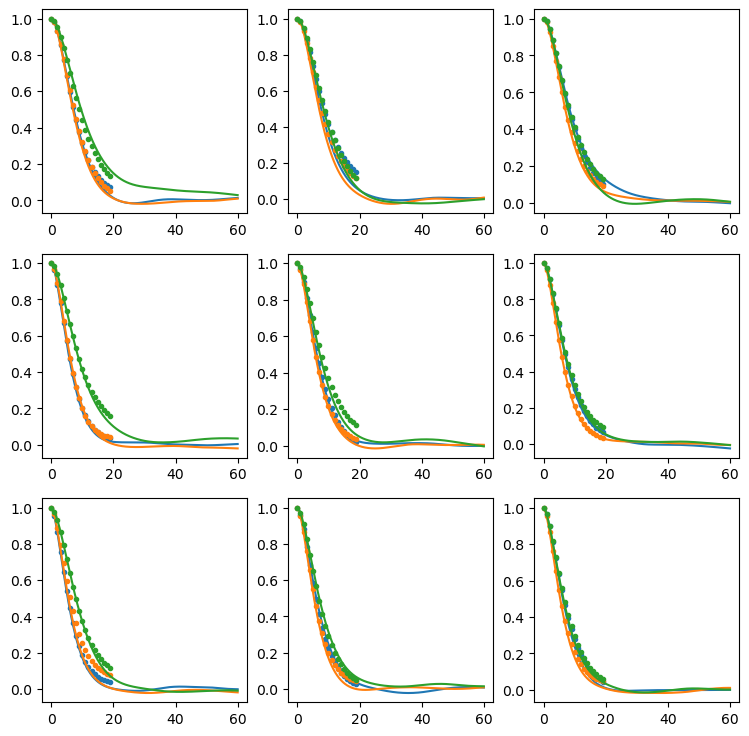

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
time_emp = np.arange(0, 20, 1)
time_theory = np.arange(0, 60, 0.04)
for i in range(3):
    for j in range(3):
        for k in [2, 3, 4]:
            s = sim_results[1][k,i,j,:,0,:]
            t = np.squeeze(theory_results[1][k,i,j])
            for i_seed in range(10):
                pass
                #ax[i,j].plot(time_emp, s[k], '.', alpha=0.1, color='C{}'.format(k))
            ax[i,j].plot(time_emp, s.mean(0)/s.mean(0)[0], '.', alpha=1, color='C{}'.format(k-2))
            ax[i,j].plot(time_theory, t[:len(time_theory)]/t[0], color='C{}'.format(k-2))

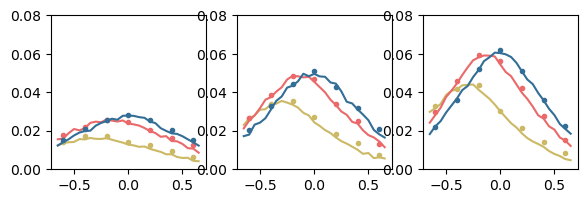

In [152]:
fig, ax = plt.subplots(1, 3, figsize=(6.8, 2))
cols = ['#CCB966', '#EA696A', '#336E96']
for i in range(3):
    for j in range(3):
        s = sim_results[1][1:-1,i,j,:,0].mean(1)
        ax[i].plot(sim_results[0]['rho_1'][1:-1], s, '.', color=cols[j])
        t = theory_results[1][3:-4,i,j,0,1]
        #c_fit = theory_results[1][:,i,j,0,2]
        ax[i].plot(theory_results[0]['rho_1'][3:-4], t, color=cols[j])
        #ax[i].plot(theory_results[0]['rho_1'], c_fit, color='k')
    ax[i].set_ylim([0, 0.08])

(0.0, 0.07)

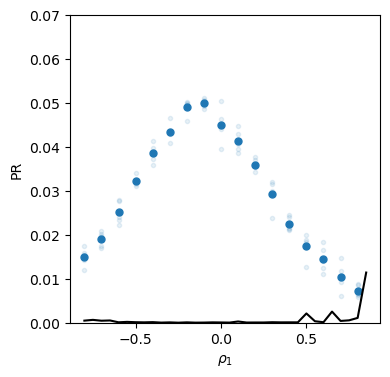

In [90]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(5):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,2], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_1$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

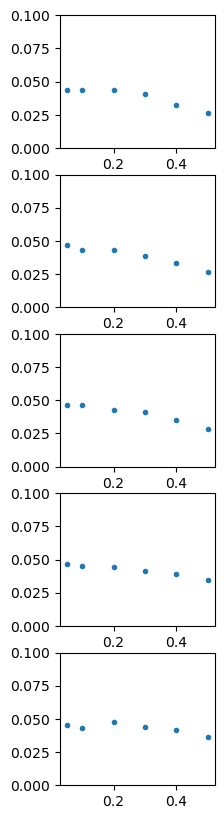

In [55]:
sim_results[0]
fig, ax = plt.subplots(5, 1, figsize=(2, 10))
for i in range(5):
    ax[i].plot(sim_results[0]['rho_max'], sim_results[1][:,i,:,0].mean(-1), '.')
    ax[i].set_ylim([0, 0.1])

(0.0, 0.07)

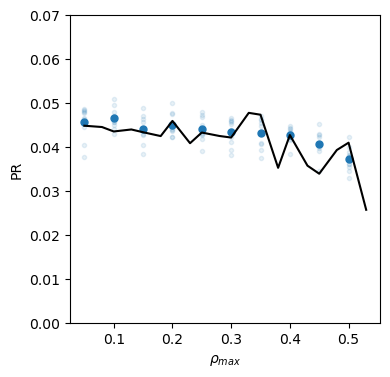

In [42]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_max'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_max'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_max'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{max}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

(0.0, 0.07)

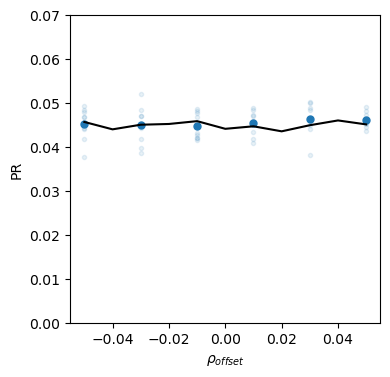

In [61]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_offset'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{offset}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')


(array([ 6.,  3.,  4.,  6.,  5.,  9., 14., 16., 22., 19.]),
 array([-3.08870297, -2.80403604, -2.51936912, -2.23470219, -1.95003526,
        -1.66536834, -1.38070141, -1.09603448, -0.81136756, -0.52670063,
        -0.2420337 ]),
 <BarContainer object of 10 artists>)

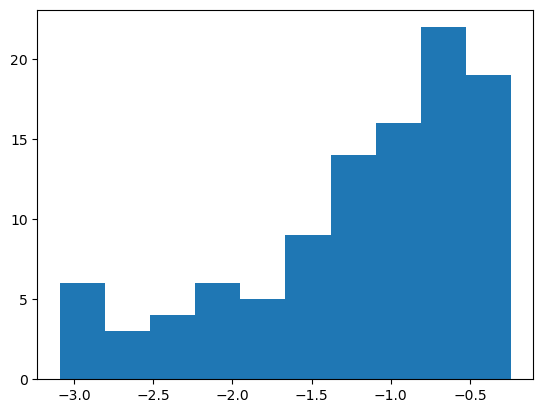

In [30]:
plt.hist(np.log10(theory_results[1][:,:,:,2].flatten()))

(0.0, 0.1)

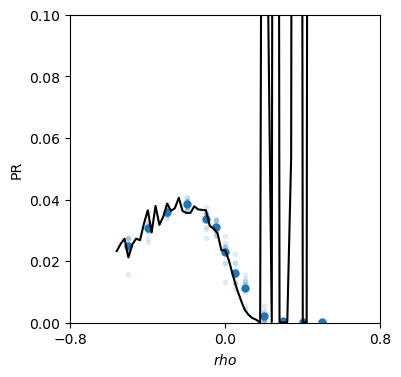

In [11]:
plt.figure(figsize=(4, 4))
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,1], color='k')
plt.xticks([-0.8, 0, 0.8])
plt.xlabel('$rho$')
plt.ylabel('PR')
plt.ylim([0, 0.1])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 1
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])